In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
columns = ['cow_id', 'lactation_number', 'event', 'days_in_milk', 'date', 'remark', 'r', 't', 'b']

breedings = pd.read_csv(
    'sample/breedings.csv',
    header=0,
    names=columns,
    converters={'event': lambda x: x.strip()})

breedings.days_in_milk = pd.to_timedelta(breedings.days_in_milk, unit='days')
breedings.date = pd.to_datetime(breedings.date, errors='coerce')
breedings['calving_date'] = breedings.date - breedings.days_in_milk

breedings.drop(['remark', 'r', 't', 'b', 'days_in_milk', 'date'], axis=1, inplace=True)
breedings = breedings.drop_duplicates().reset_index(drop=True)

# find weird entries, remove, and log
cow_groups = breedings.sort_values(by=['cow_id', 'event', 'calving_date']).groupby(by=['cow_id', 'event'])
duplicate_births = breedings[cow_groups.calving_date.diff() <= pd.Timedelta(days=280)]
indices = (duplicate_births.index-1).append(duplicate_births.index).sort_values()
duplicate_births = breedings.loc[indices, :]
if len(duplicate_births) > 0:
    print('Duplicate births:')
    print(duplicate_births)
    breedings = breedings[~breedings.isin(duplicate_births)].dropna()

breedings = breedings.sort_values(by=['cow_id'])
# breedings.to_csv('sample cleaned/breedings.csv', index=False)

In [9]:
def plot_data(df, cow_id):
    ax = plt.gca()
    ax.set_title(cow_id)

    min_date = min(df.index)
    max_date = max(df.index)
    df.reset_index().plot(kind='line', x='time', y='temp_without_drink_cycles', ax=ax, figsize=(30, 10), xticks=np.arange(min_date, max_date, pd.Timedelta(days=21)))
    df.reset_index().plot(kind='line', x='time', y='activity', color='red', ax=ax)

    # pregnacy
    for date in breedings[breedings.cow_id == cow_id].calving_date:
        pregnancy = (date - pd.Timedelta(days=283), date)
        if pregnancy[1] > min_date and pregnancy[0] < max_date:
            ax.axvspan(pregnancy[0], pregnancy[1], color='purple', alpha=0.25)

    plt.show()

In [23]:
cows = dict()
columns = ['act_heat_index', 'act_heat_index_smart', 'activity', 'heat_index', 'activity_1day_avg', '60percentile_of_5day_temp', 'temp', 'temp_dec_index', 'temp_height_index', 'temp_inc_index', 'temp_without_drink_cycles', 'time', 'cow_id']

for file_name in os.listdir('sample/'):
    if file_name != 'breedings.csv' and file_name.split('.')[1] == 'csv':
        data = pd.read_csv('sample/' + file_name, parse_dates=['time'])
        
        data.columns = columns
        data = data[~data.activity_1day_avg.isnull()]
#         data = data[['activity', 'temp_without_drink_cycles', 'time', 'cow_id']]
        data.sort_values(by='time', inplace=True)
        data = data.reset_index(drop=True)
        
        # checks for missing data at beginning/ end and removes it
        missing = data.iloc[:14*24*6][data.iloc[:14*24*6].time.diff().dt.seconds % 600 != 0].iloc[1:]
        if (len(missing) > 0):
            data = data.iloc[missing.iloc[-1].name + 1:]
        
        # checks for outliers at beginning and removes them
        outliers = data.iloc[:14*24*6][((data.activity - data.activity.mean()).rolling(5).mean().abs() > 3 * data.activity.std()) | ((data.temp_without_drink_cycles - data.temp_without_drink_cycles.mean()).rolling(5).mean().abs() > 3 * data.temp_without_drink_cycles.std())]
        if len(outliers) > 0:
            data = data.iloc[outliers.iloc[-1].name + 1:]
        
        data.set_index('time', drop=True, inplace=True)

        # smoothing
        data.temp_without_drink_cycles = data.temp_without_drink_cycles.rolling(12*6, min_periods=1, center=True).mean()
        data.activity = data.activity.rolling(24*6, min_periods=1, center=True).mean()

        # fill in missing data, in chunks b/c sometimes the time difference changes
        new_data = []
        prev = min(data.index)
        for i, x in data[(data.reset_index().time.diff().dt.seconds % 600 != 0).values].iloc[1:].iterrows():
            new_data.append(data.loc[prev:i].reindex(pd.date_range(prev, i, freq=pd.Timedelta(minutes=10))))
            prev = i
        new_data.append(data.loc[prev:].reindex(pd.date_range(prev, max(data.index), freq=pd.Timedelta(minutes=10))))
        
        data = pd.concat(new_data)
        data.index.name = 'time'
        data.interpolate(method='time', inplace=True)
        data.cow_id = data.cow_id.astype(int)
      
        cow_id = data.cow_id.unique()[0]
#         plot_data(data, cow_id)
        cows[cow_id] = data
        data.to_csv('sample cleaned2/' + str(cow_id) + '.csv', index=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


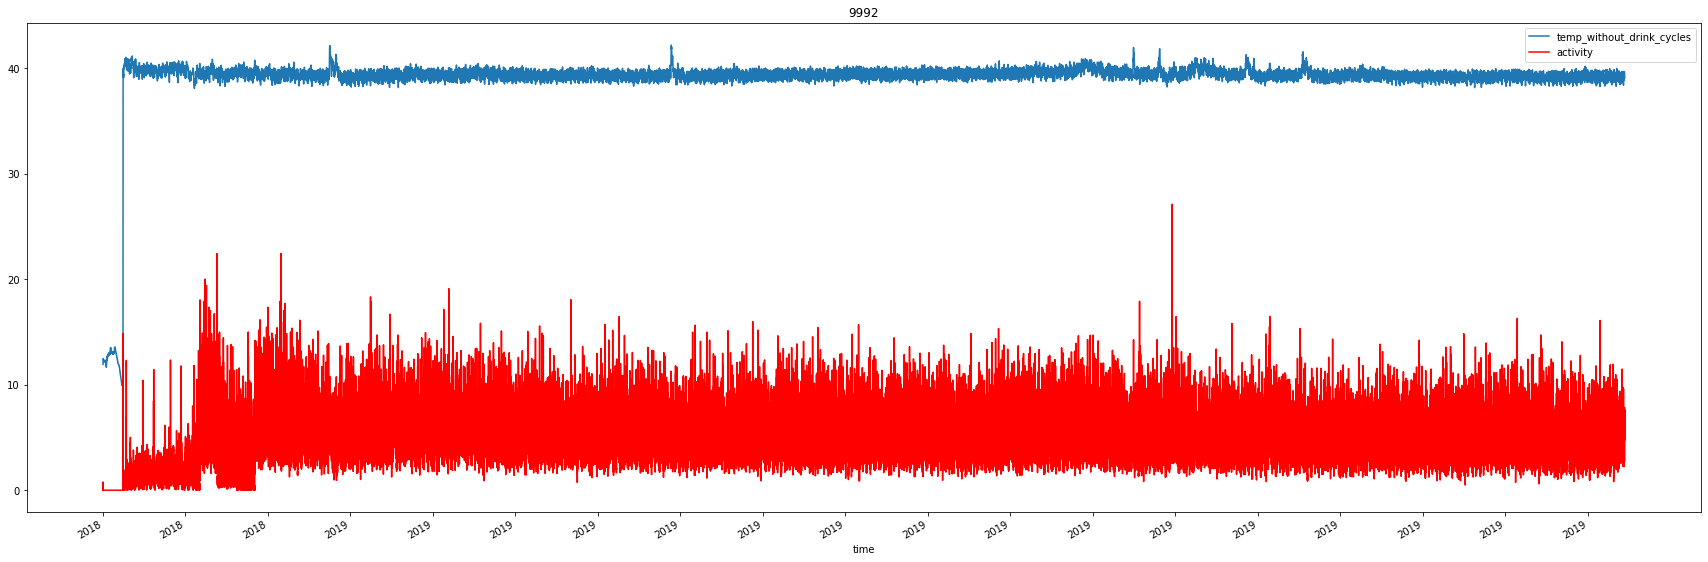

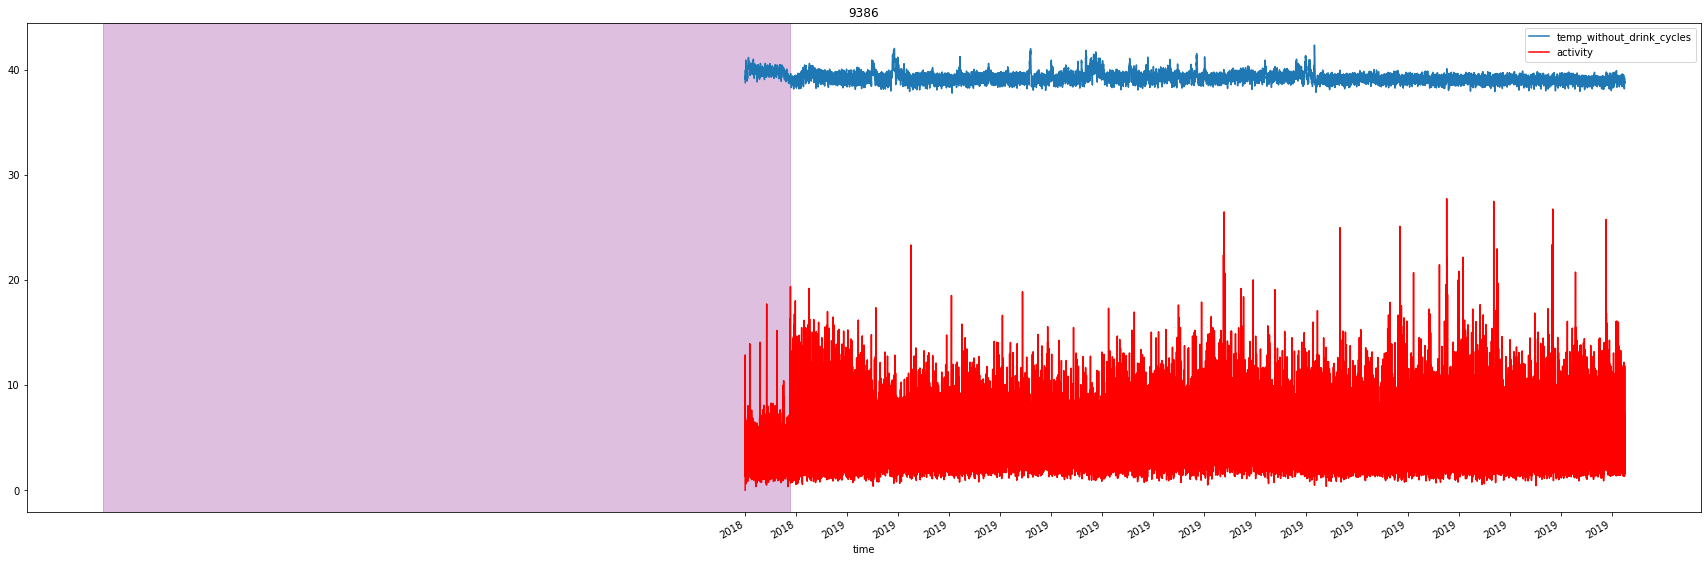

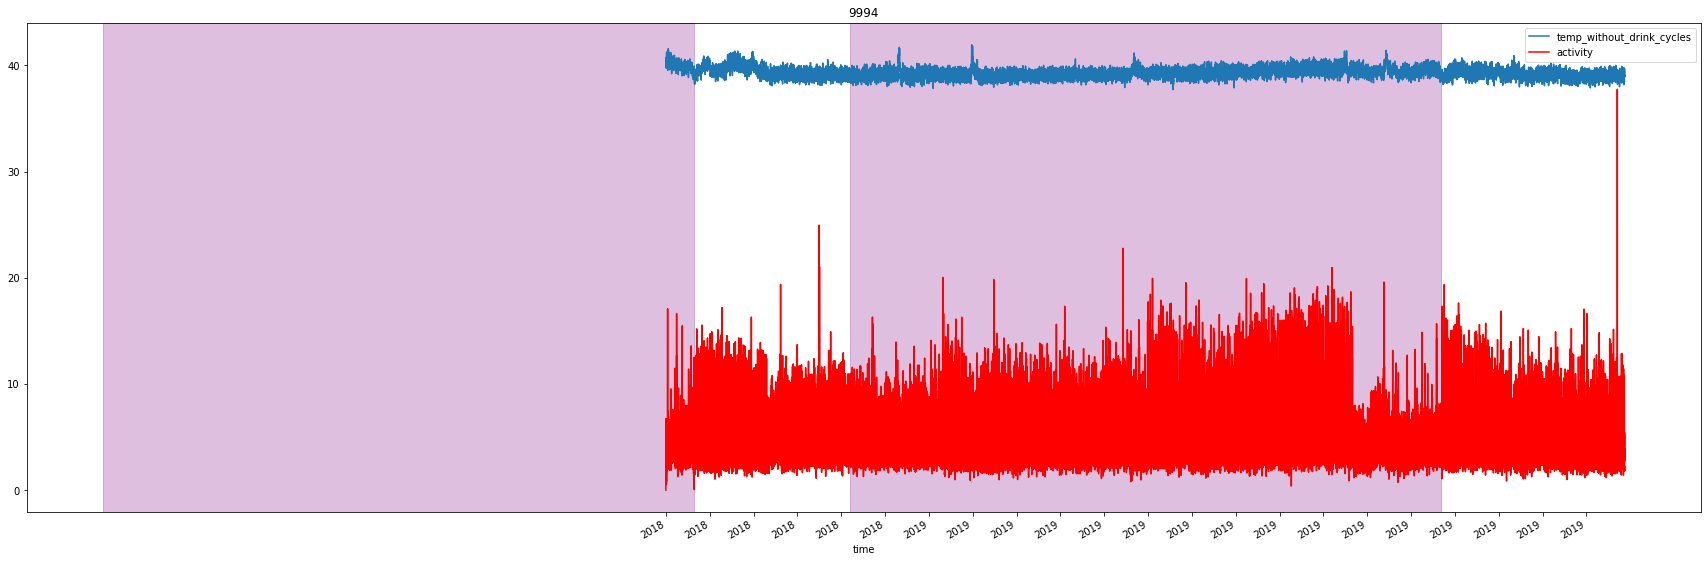

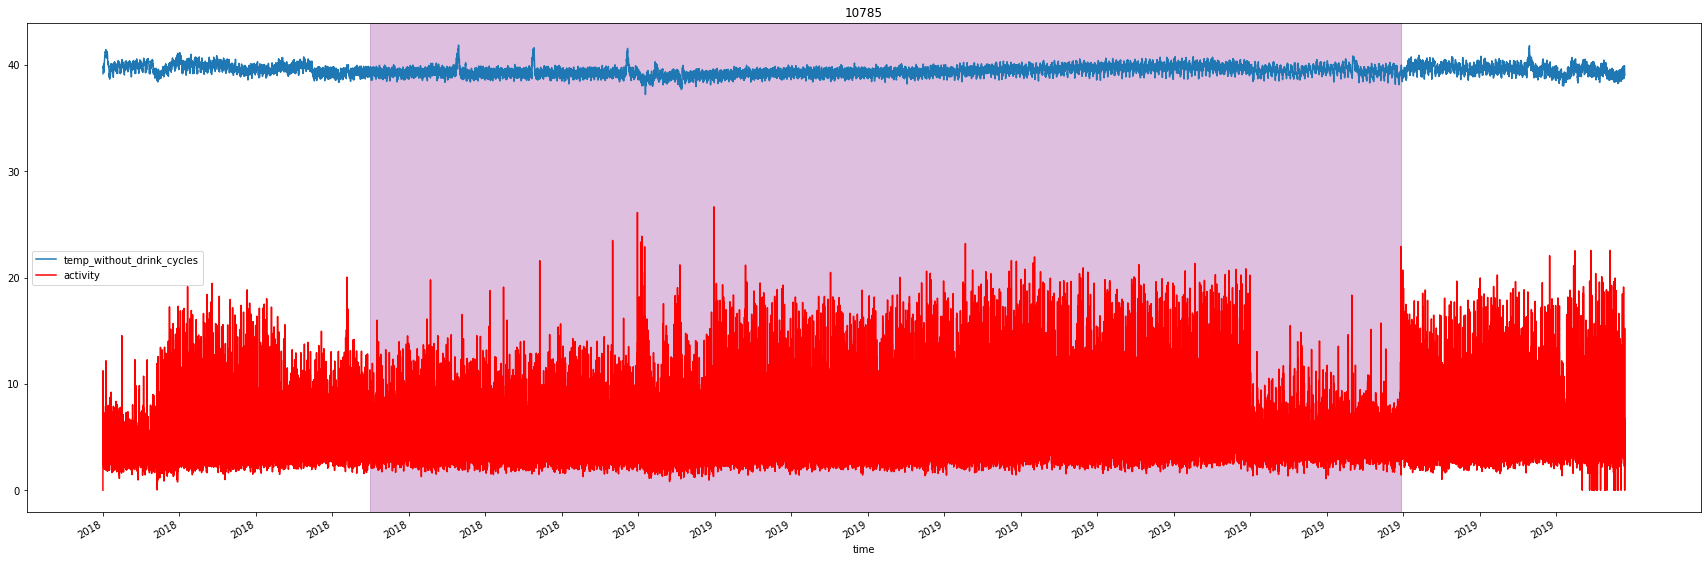

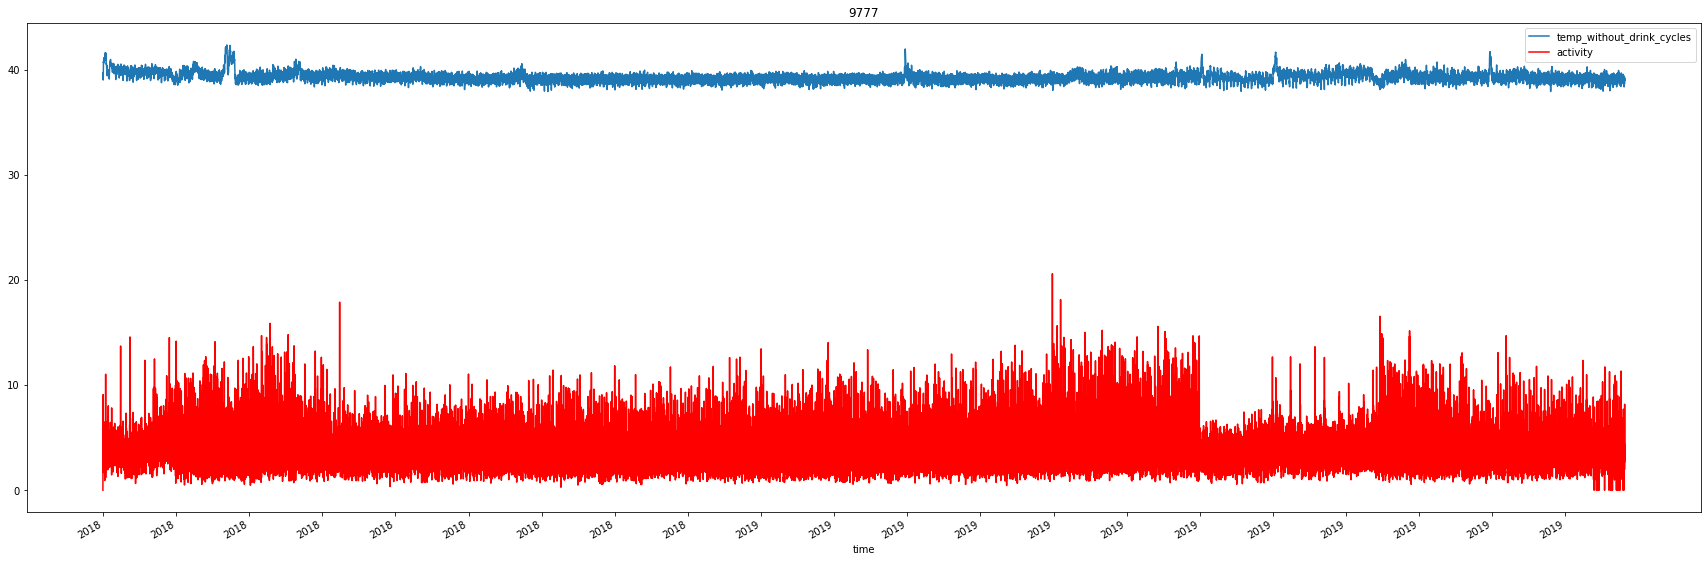

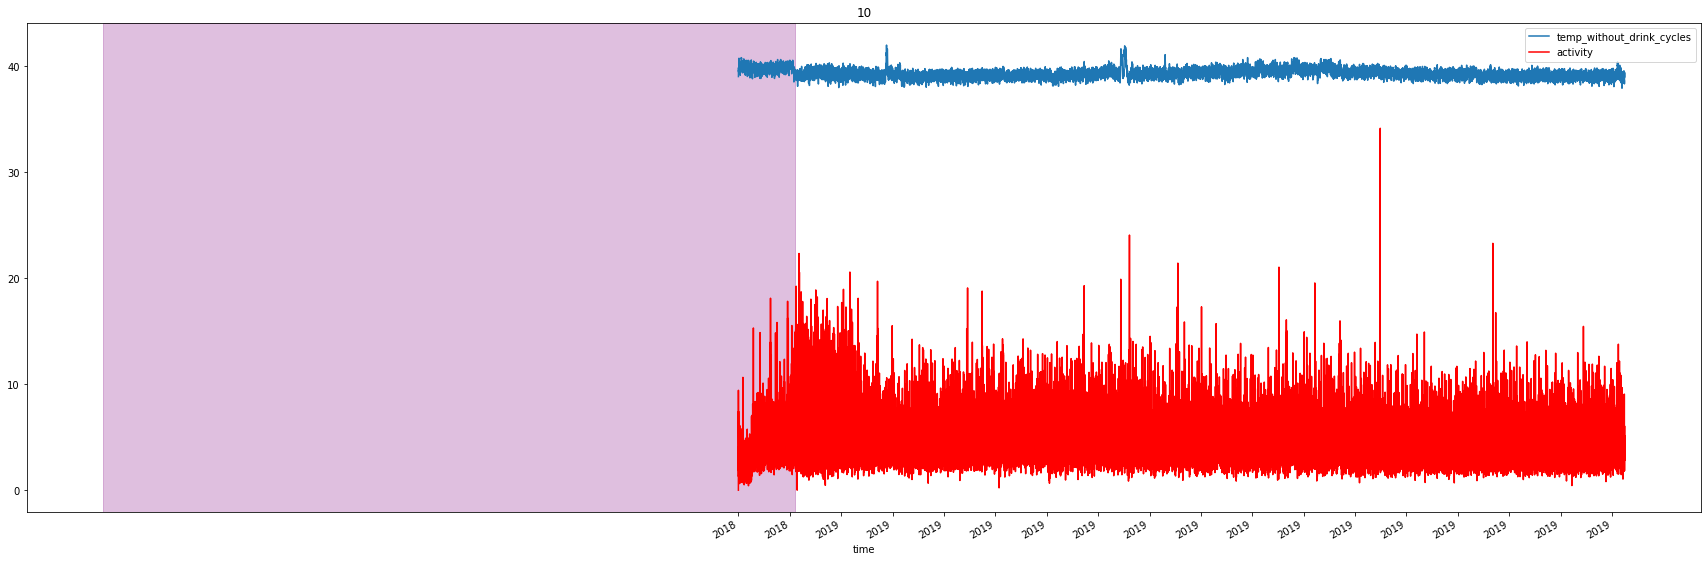

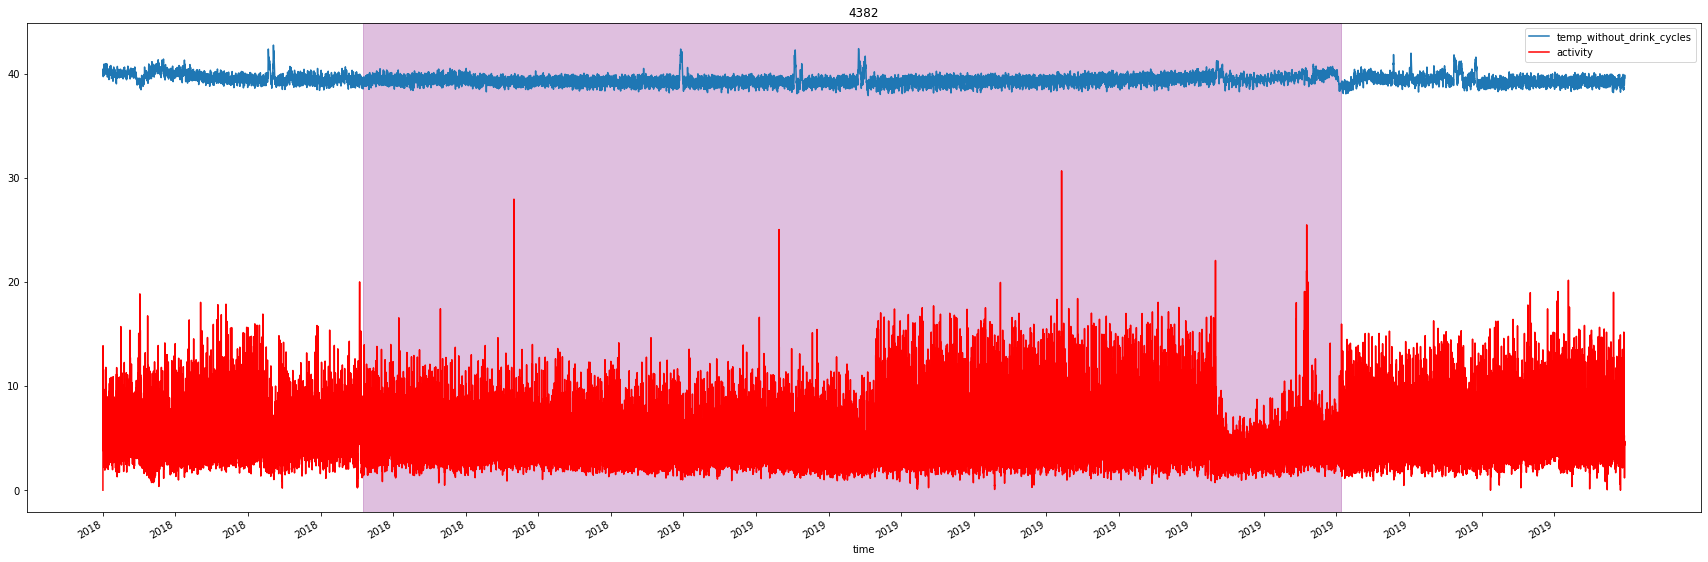

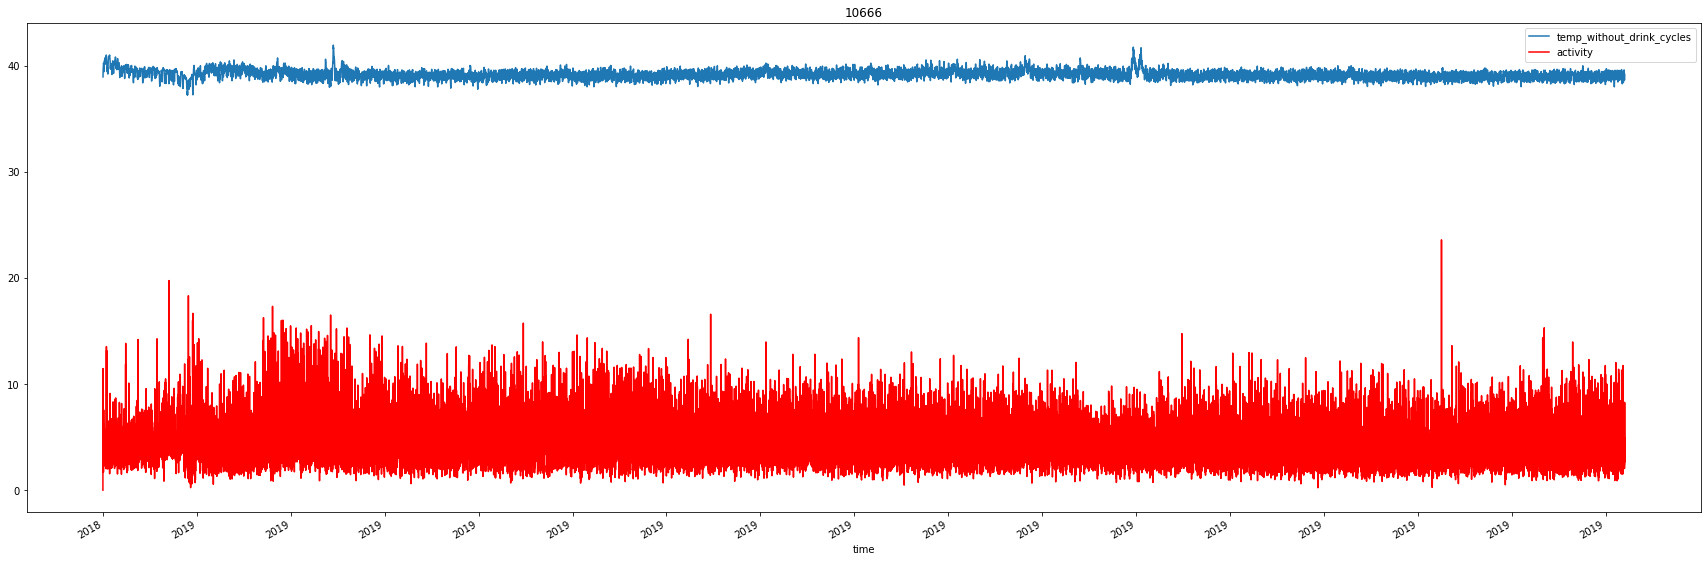

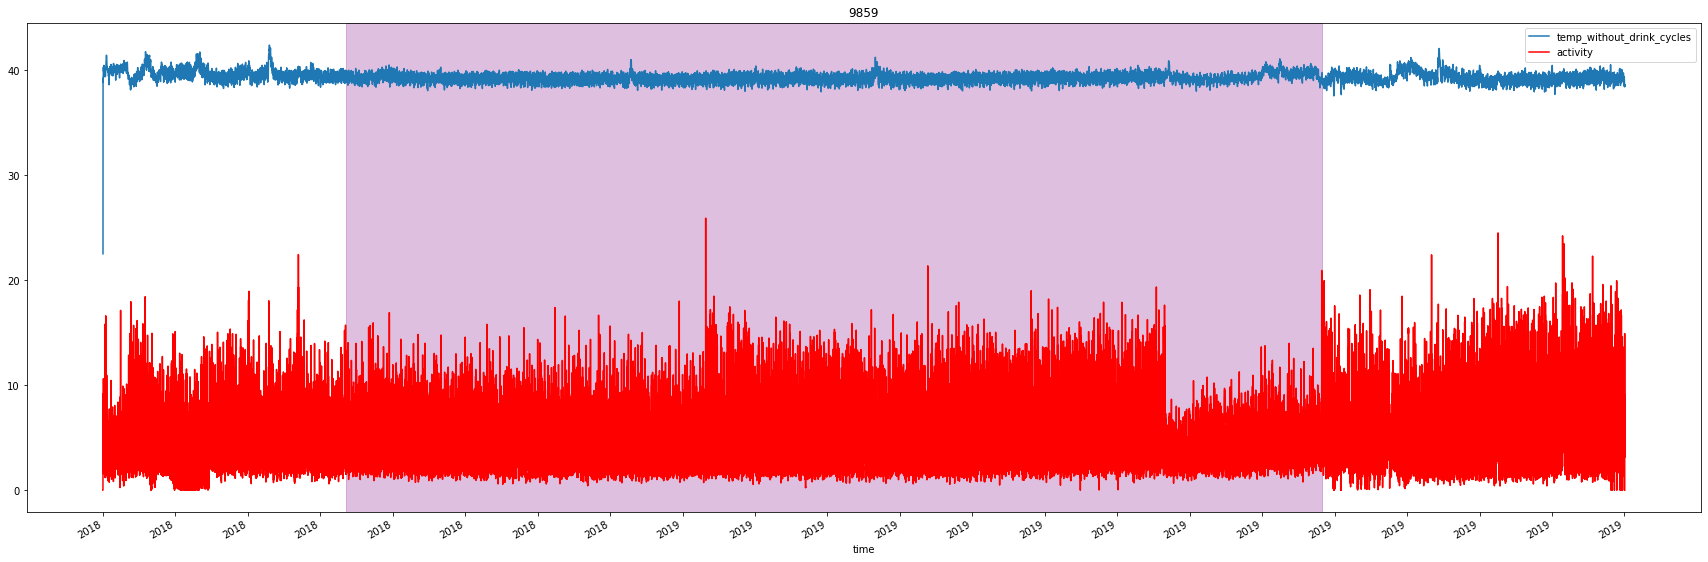

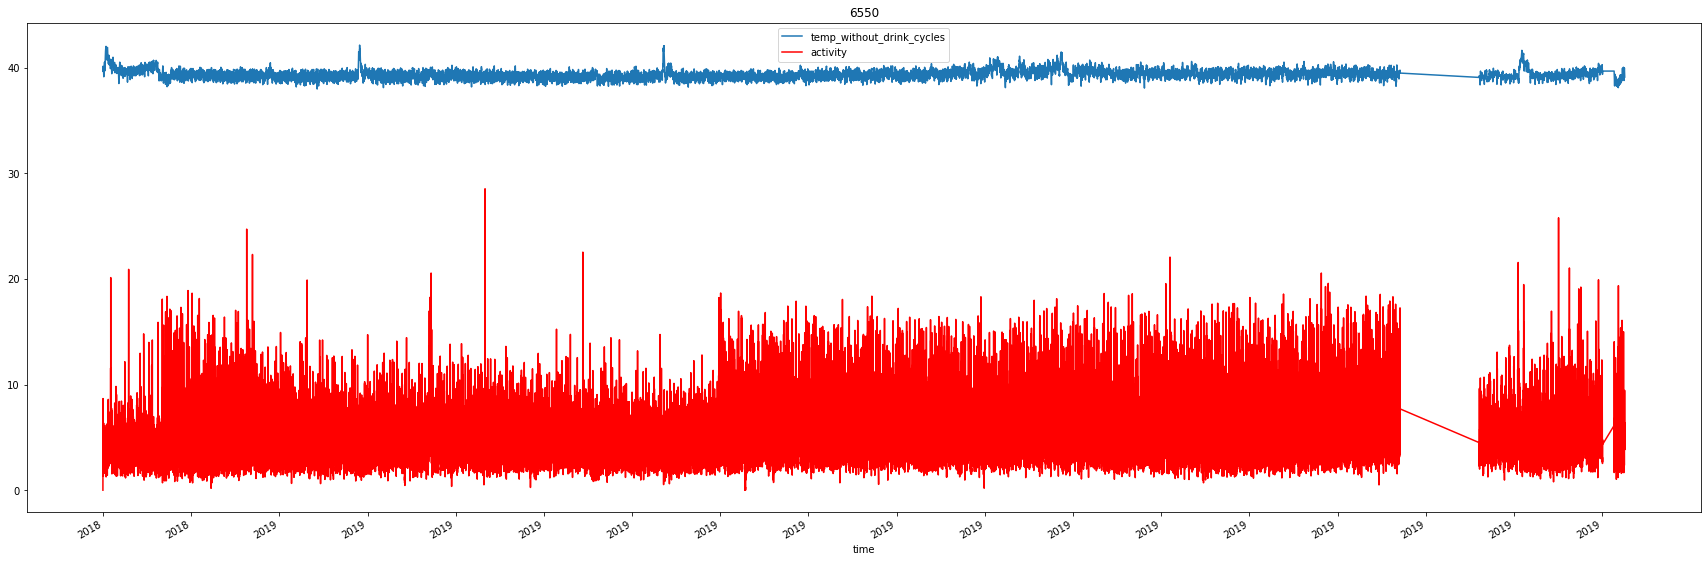

In [12]:
columns = ['act_heat_index', 'act_heat_index_smart', 'activity', 'heat_index', 'activity_1day_avg', '60percentile_of_5day_temp', 'temp', 'temp_dec_index', 'temp_height_index', 'temp_inc_index', 'temp_without_drink_cycles', 'time', 'cow_id']

for file_name in os.listdir('sample/'):
    if file_name != 'breedings.csv' and file_name.split('.')[1] == 'csv':
        data = pd.read_csv('sample/' + file_name, parse_dates=['time'])
        
        data.columns = columns
        data = data[~data.activity_1day_avg.isnull()]
        data = data[['activity', 'temp_without_drink_cycles', 'time', 'cow_id']]
        data.sort_values(by='time', inplace=True)
        data = data.reset_index(drop=True)
                
        data.set_index('time', drop=True, inplace=True)

        cow_id = data.cow_id.unique()[0]
        plot_data(data, cow_id)


In [21]:
for file_name in os.listdir('sample/'):
    if file_name != 'breedings.csv' and file_name.split('.')[1] == 'csv':
        data = pd.read_csv('sample/' + file_name, parse_dates=['time'])
        data.sort_values(by='time', inplace=True)
        data = data.reset_index(drop=True)
        
        before = data[data.time < pd.Timestamp('2019-09-01')]
        after = data[data.time >= pd.Timestamp('2019-09-01')]
        
        cow_id = data['CowID'].unique()[0]
        before.to_csv('before/' + str(cow_id) + '.csv', index=False)
        after.to_csv('after/' + str(cow_id) + '.csv', index=False)